# Data Science Essentials: GeoPandas
    Maxwell Nielsen
    Section 001
    9/27/2022

In [1]:
! pip install geopandas
from google.colab import files
import geopandas as gpd
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from shapely.geometry import Point, Polygon
from matplotlib.colors import LogNorm
from matplotlib.cm import ScalarMappable
from matplotlib import animation
#! pip install HTML
from IPython.display import HTML
%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Problem 1

Read in the file *airports.csv* as a pandas dataframe.
Create three convex hulls around the three sets of airports listed below.
This can be done by passing in lists of the airports' coordinates to a *shapely.geometry.Polygon* object.

1. Maio Airport, Scatsta Airport, Stokmarknes Skagen Airport, Bekily Airport, K. D. Matanzima Airport, RAF Ascension Island
2. Oiapoque Airport, Maio Airport, Zhezkazgan Airport, Walton Airport, RAF Ascension Island, Usiminas Airport, Piloto Osvaldo Marques Dias Airport
3. Zhezkazgan Airport, Khanty Mansiysk Airport, Novy Urengoy Airport, Kalay Airport, Biju Patnaik Airport, Walton Airport
	
Create a new GeoDataFrame with these three Polygons as entries.
Plot this GeoDataFrame on top of an outlined world map.

In [2]:
airport = pd.read_csv('airports.csv')     #read in the file

Text(57.875, 0.5, 'Latitude')

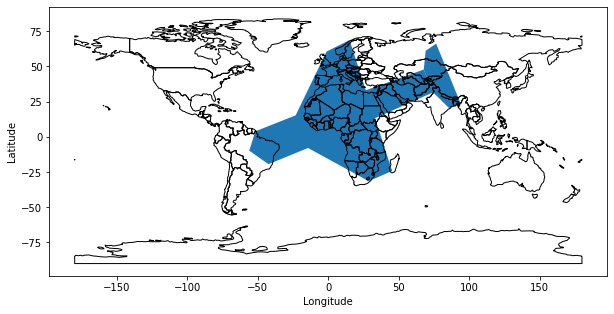

In [3]:
first_set = ['Maio Airport', 'Scatsta Airport', 'Stokmarknes Skagen Airport',
                 'Bekily Airport','K. D. Matanzima Airport', 'RAF Ascension Island']
second_set = ['Oiapoque Airport','Maio Airport', 'Zhezkazgan Airport',
                'Walton Airport','RAF Ascension Island','Usiminas Airport',
                 'Piloto Osvaldo Marques Dias Airport']
third_set = ['Zhezkazgan Airport','Khanty Mansiysk Airport','Novy Urengoy Airport',
                 'Kalay Airport','Biju Patnaik Airport','Walton Airport']

airport['Coordinates'] = list(zip(airport.Longitude, airport.Latitude))     #convert data to GeoDataFrame
airport['Coordinates'] = airport.Coordinates.apply(Point)
airport = gpd.GeoDataFrame(airport, geometry='Coordinates')

airport.set_index('Name', inplace=True)   #set the index of gdp to name of airport

first_cods = airport.loc[first_set]
second_cods = airport.loc[second_set]     #get the gpd info for each airport
third_cods = airport.loc[third_set]

first_pol = Polygon(list(zip(first_cods.Longitude, first_cods.Latitude))).convex_hull
second_pol = Polygon(list(zip(second_cods.Longitude, second_cods.Latitude))).convex_hull
third_pol = Polygon(list(zip(third_cods.Longitude, third_cods.Latitude))).convex_hull     #create the three convex hulls

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
fig, ax = plt.subplots(figsize=(10,7), ncols=1, nrows=1)            #load the earth outline map
base = world.boundary.plot(edgecolor='black', ax=ax, linewidth=1)

frame = gpd.GeoDataFrame({'geometry': [first_pol,second_pol,third_pol]})      #create another GeoDataFrame out of the polygons
frame.plot(ax=base)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

## Problem 2
Use the command *geopandas.read_file('county_data.gpkg')* to create a GeoDataFrame of information about US counties.
Each county's shape is stored in the *geometry* column.
Use this to **plot the outlines of all US counties two times**, first using the default CRS and then using EPSG:5071.

Next, create a new GeoDataFrame that combines all counties within a single state.
Drop states with the following STATEFP codes: 02, 15, 60, 66, 69, 72, 78.
Plot this GeoDataFrame to see an outline of the 48 contiguous states.
Ensure a CRS of 5071.

In [4]:
#upload 'county.gpkg.zip'
county = files.upload()
!unzip county_data.gpkg.zip
county_df = gpd.read_file('county_data.gpkg')

Saving county_data.gpkg.zip to county_data.gpkg (2).zip
Archive:  county_data.gpkg.zip
replace county_data.gpkg/county_data.cpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
 extracting: county_data.gpkg/county_data.cpg  
replace county_data.gpkg/county_data.dbf? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: county_data.gpkg/county_data.dbf  
replace county_data.gpkg/county_data.prj? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: county_data.gpkg/county_data.prj  
replace county_data.gpkg/county_data.shp? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: county_data.gpkg/county_data.shp  
replace county_data.gpkg/county_data.shx? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: county_data.gpkg/county_data.shx  


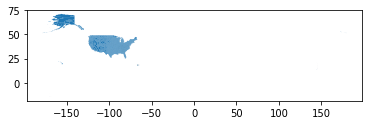

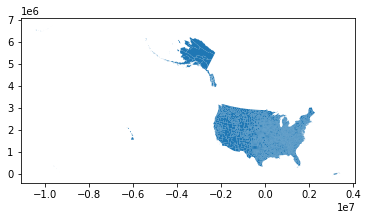

In [5]:
counts = county_df[['geometry']]   #get the geometry of each county
counts.plot()
new = counts.to_crs(5071)     #convert the crs and plot again
new.plot()

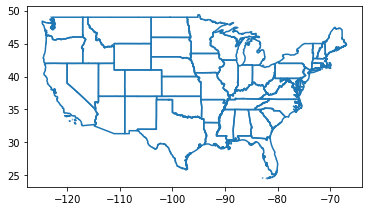

In [6]:
county_df.set_index('STATEFP',inplace=True)       #set the index of the dataframe to be the state fp
county_df.drop(index=['02','15','60','66','69','72','78'],inplace=True)     #drop the non contiguous tates
state_df = county_df.dissolve(by="STATEFP")         #merge into a single GeoSeries and plot
state_df.boundary.plot()

## Problem 3

Load in the file *nytimes.csv* as a DataFrame.
This file includes county-level data for the cumulative cases and deaths of Covid-19 in the US, starting with the first case in Snohomish County, Washington, on January 21, 2020.
**First, convert the *date* column into a *DatetimeIndex*.**

Next, use county FIPS codes to **merge your GeoDataFrame from the previous problem with the DataFrame you just created.**
A FIPS code is a 5-digit unique identifier for geographic locations.
For this lab, we will ignore rows in the Covid-19 DataFramw tih unknown FIPS codes.
Also, we will just be examining data from the contiguous US, so **drop all data from Hawaii and Alaska.**

Note that the *fips* column of the Covid-19 DataFrame stores entries as floats, but the county GeoDataFrame stores FIPS codes as strings, with the first two digits in the *STATEFP* column and the last three in the *COUNTYFP* column.

**Plot the cases from March 21, 2020 on top of your state outline map from the previous problem.
Finally, print out the name of the county with the most cases along with its case count.**

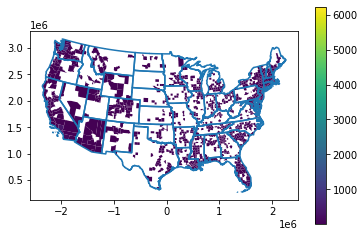

New York City 6226


In [7]:
ny_dat = pd.read_csv('nytimes.csv')     #read in the file
ny_dat['dates'] = pd.to_datetime(ny_dat['date'])
ny_dat.rename(columns={'fips': 'FIPS'}, inplace=True) #rename fips column

county_df = gpd.read_file('county_data.gpkg')

county_df['FIPS'] = county_df['STATEFP'] + county_df['COUNTYFP']
county_df['FIPS'] = county_df['FIPS'].astype(float)     #add the two fips columns and recast

county_df = county_df.merge(ny_dat, on='FIPS')       #merge the two data frames

county_df = county_df[county_df['FIPS'] != 0]

county_df = county_df[~county_df['state'].isin(['Hawaii', 'Alaska'])]     #drop alaska and hawaii

county_df = gpd.GeoDataFrame(county_df)

ax = state_df.to_crs(epsg=5071).boundary.plot()

march21 = county_df[county_df['date'] == '2020-03-21']     #isolate march 21 data

march21.to_crs(epsg=5071).plot(ax=ax, column='cases', legend=True)

plt.show()       #plot the cases

print(march21.groupby("county")['cases'].max().idxmax(), march21['cases'].max())



## Problem 4

As in Problem 3, plot your state outline map together with a map of Covid-19 cases from March 21, 2020.
This time, use a log scale.
Use EPSG:5071.
Pick a good colormap and be sure to display a colorbar.

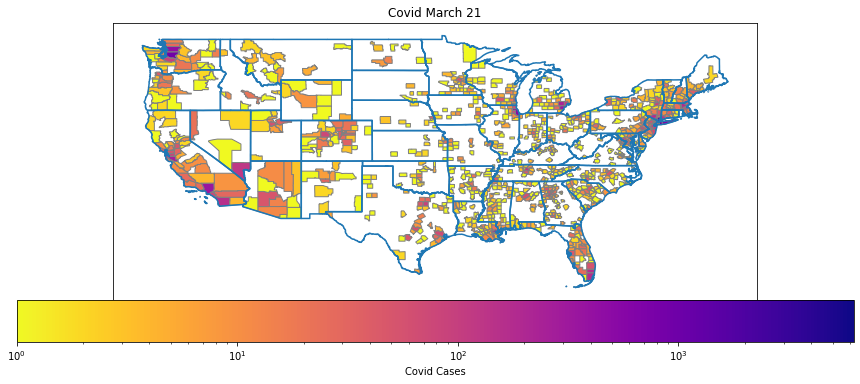

In [8]:
fig, ax = plt.subplots(figsize=(15,6), ncols=1, nrows=1)
data = march21.cases

norm = LogNorm(vmin=min(data), vmax=max(data))   #create our norm

state_df.boundary.plot(ax=ax)
march21.plot(column='cases', cmap='plasma_r', ax=ax, edgecolor='gray', norm=norm)   #plot cases on log scale

cbar = fig.colorbar(ScalarMappable(norm=norm, cmap='plasma_r'), ax=ax, orientation='horizontal', pad=0, label='Covid Cases')   #create colorbar

ax.set_title('Covid March 21')

ax.set_yticks([])

ax.set_xticks([])

plt.show()


## Problem 5
In this problem, you will create an animation of the spread of Covid-19 through US counties from January 21, 2020 to June 21, 2020.
Use a log scale and a good colormap, and be sure that you're using the same norm and colorbar for the whole animation.
Use EPSG:5071 for the CRS.

As a reminder, below is a summary of what you will need in order to animate this map.
You may also find it helpful to refer to the animation section included with the Volume 4 lab manual. 

- Set up your figure and norm. Be sure to use the highest case count for your vmax so that the scale remains uniform.
- Write your update function. This should plot the cases from a given day.
- Set up your colorbar. Do this outside the update function to avoid adding a new colorbar each day.
- Create the animation. Check to make sure everything displays properly before you save it.
- Save the animation.
- Display the animation.

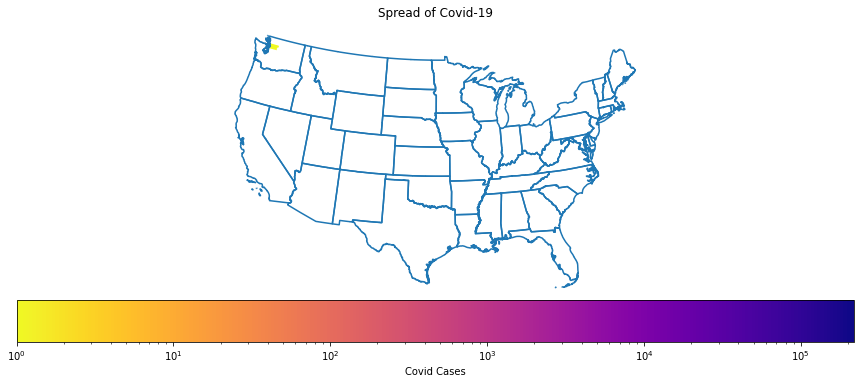

In [9]:
#Set up figure and norm
state_df.to_crs(epsg=5071, inplace=True)     #convert crs
county_df = gpd.GeoDataFrame(county_df, geometry='geometry').to_crs(5071)    #make into a geo data frame

fig, ax = plt.subplots(figsize=(15,6), ncols=1, nrows=1)
data = county_df.cases

norm = LogNorm(vmin=min(data), vmax=max(data))      #create our norm

def update(date):
    ax.clear()
    ax.set_title("Spread of Covid-19")                    #create our update function
    state_df.boundary.plot(ax=ax)
    county_df[county_df['date']==date].plot(ax=ax, cmap = 'plasma_r', column='cases', norm=norm)  
    ax.axis('off')
    

cbar = fig.colorbar(ScalarMappable(norm=norm, cmap='plasma_r'), ax=ax, orientation='horizontal', pad=0, label='Covid Cases')    #Set up the colorbar


anim = animation.FuncAnimation(fig, update, frames=county_df['date'].drop_duplicates().sort_values(ascending=True), interval=100)  #Create the animation
anim.save('map.mp4')



<video src='map.mp4' controls></video>

<video src='map.mp4' controls></video>

In [10]:
HTML(anim.to_html5_video())

<Figure size 432x288 with 0 Axes>

<video src='your_video_name.mp4' controls width=800>